<a href="https://colab.research.google.com/github/ferit-osirv/lab3/blob/main/lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 3 - Image Compression and Frequency Analysis

**This command must be run before starting to do each lab.**

In [2]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

## Color Quantization

Quantization in the context of image processing is a technique that reduces the number of distinct pixel values used to represent an image. It achieves this by mapping a range of values to a single quantum value, effectively reducing the image's color depth or the number of bits required per pixel. This process is a fundamental aspect of lossy image compression, where the goal is to decrease the size of the image file at the cost of a reduction in image quality.

![](https://upload.wikimedia.org/wikipedia/commons/e/e3/Dithering_example_undithered.png)

![](https://upload.wikimedia.org/wikipedia/commons/4/48/Dithering_example_undithered_16color_palette.png)

The above image was quantized to 16 colors using a color palette. The quantized image on the bottom has a reduced color depth compared to the original image on the top.

**In the context of image compression**, color quantization is used in the GIF image format, while YCbCr chroma quantization is used in JPEG compression. The YCbCr color space separates the luminance (Y) from the chrominance (Cb and Cr) components, allowing for more efficient compression by quantizing the chroma channels more aggressively than the luminance channel.

![width=20%](https://upload.wikimedia.org/wikipedia/commons/thumb/d/d9/Barns_grand_tetons_YCbCr_separation.jpg/241px-Barns_grand_tetons_YCbCr_separation.jpg)

In the above image, you can see the original image and then the Y, Cr and Cb channels separately. The Y channel contains the luminance information, while the Cr and Cb channels contain the chrominance information. Notice how the Y channel contains almost all information in the image: You can tell the mountains, the barn, and the trees just by looking at the Y channel.

> ### Assignment 1: Color and Chroma Quantization
>
>1. **RGB Color Quantization:**
>   - Load an RGB image, where each channel is initially 8 bits.
>   - Quantize to 7 bits per channel by mapping the 256 original levels to 128.
>   - Calculate the compression ratio (how many bits are needed to represent the original image vs. the quantized image).
>
>2. **YCbCr Chroma Quantization:**
>   - Convert the RGB image to YCbCr using `cv2.cvtColor()`. Y represents luminance; Cb and Cr represent chrominance.
>   - Perform quantization on the Cb and Cr channels to reduce color detail. I.e. reduce chroma resolution by a factor of 2 so that there are 128 unique levels.
>   - Compute the compression ratio and compare with RGB quantization.
>
>3. **Analysis:**
>   - Display the original, color quantized, and chroma quantized images for visual comparison.
>   - Evaluate the compression ratios and discuss the balance between compression efficiency and image fidelity.
>   - What is the difference when quantizing color channels vs. chroma channels? Why might chroma quantization be more efficient?

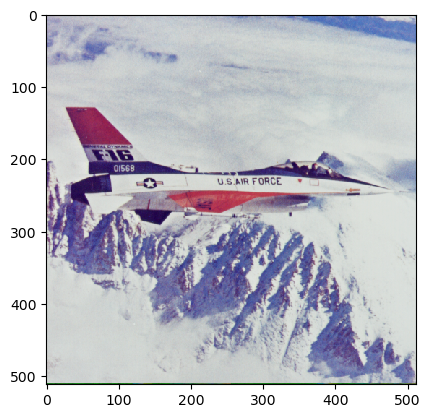

Compression Ratio: 1.1428571428571428


In [16]:
img = cv.imread('./slike/airplane.bmp')
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
widht, height, channles = img.shape
new_img = img.copy()

for i in range(widht):
    for j in range(height):
        new_img[i, j, :] = img[i, j, :] // 2 * 2

plt.imshow(new_img)
plt.show()

original_bits = 8 * img.size  
quantized_bits = 7 * img.size 
compression_ratio = original_bits / quantized_bits

print(f"Compression Ratio: {compression_ratio}")

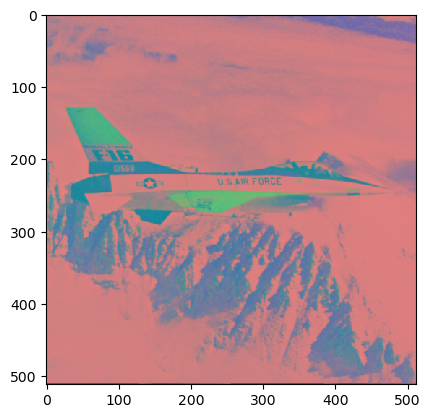

In [22]:
new_img = cv.cvtColor(img, cv.COLOR_RGB2YCR_CB)
plt.imshow(new_img)
plt.show()

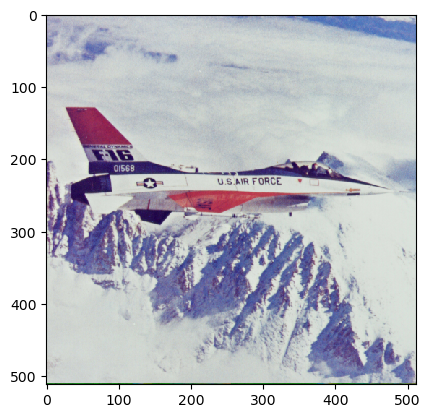

In [27]:
new_img[:, :, 1] = new_img[:, :, 1] // 2 * 2
new_img[:, :, 2] = new_img[:, :, 2] // 2 * 2

new_img = cv.cvtColor(new_img, cv.COLOR_YCR_CB2RGB)

plt.imshow(new_img)
plt.show()

## Fourier Transform

Consider the following function:

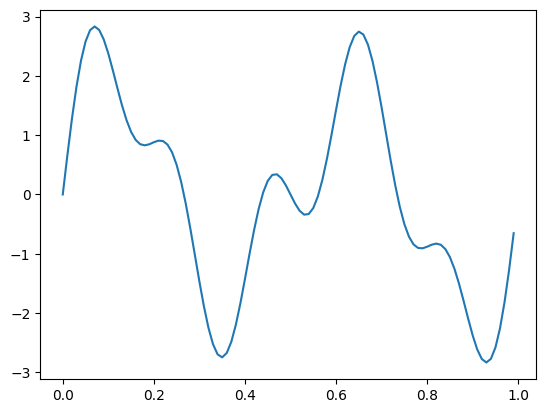

In [11]:
t = np.arange(0, 1, 0.01)
x1 = 1 * np.sin(2 * np.pi * 5 * t)
x2 = 2 * np.sin(2 * np.pi * 2 * t)
x3 = 0.5 * np.sin(2 * np.pi * 3 * t)
x = x1 + x2 + x3
plt.plot(t, x)

> **Question**: x is a sum of three sine signals. What are the amplitudes and frequencies (in Hz) of each of those signals?

Amplitude 1, freq = 5hz \
Amplitude 2, freq = 2hz \
Amplitude 0.5, freq = 3hz 

Let's check your answer using the **Fourier transform** (fft).

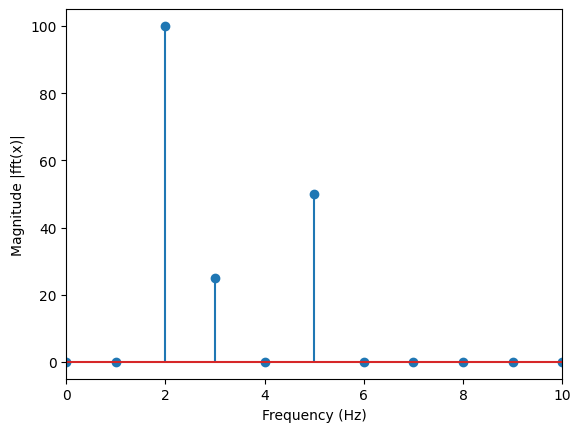

In [ ]:
fft_result = np.fft.fft(x)
plt.stem(np.abs(fft_result))
plt.xlim(0, 10)
plt.ylabel('Magnitude |fft(x)|')
plt.xlabel('Frequency (Hz)')

As you can see, the Fourier Transform decomposes a signal into a sum of sinusoids and gives us the frequencies, amplitudes, and phases of each of the components. In fact, we can see how much each of the frequencies contributes to `x` in order, 2 being the largest, then 5 and finally 3.

We can see those magnitutes here, arranged in order of frequencies from 0 to 9:

In [29]:
print(np.round(np.abs(fft_result), 2)[:10])

[  0.   0. 100.  25.   0.  50.   0.   0.   0.   0.]


We saw that f = 3 has the lowest impact (magnitude) on the signal. What happens if we remove it?

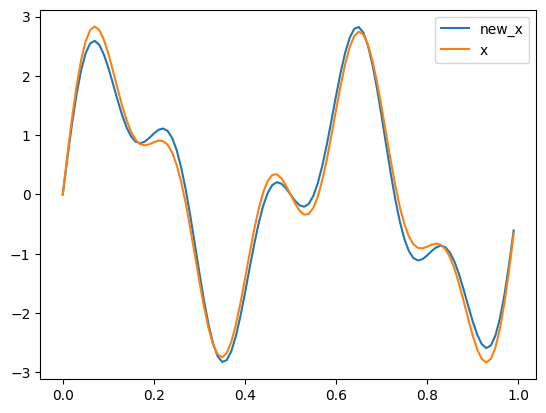

In [30]:
new_fft = fft_result.copy()

# remove f = 3 from the signal
new_fft[3] = 0

# use inverse fft to get the new signal with f = 3 removed
new_x = np.fft.ifft(new_fft)
plt.plot(t, new_x)
plt.plot(t, x)
plt.legend(['new_x', 'x']);

Because we removed the least important frequency, the signal is almost the same! That is the gist of image compression.

**Image compression works by removing data that with the smallest contribution to the image. The Fourier Transform lets us decompose any function (including images) into a list of sine waves and gives us the contribution of each sine wave to the total image.**

Thus, we can use the Fourier transform to compress images.

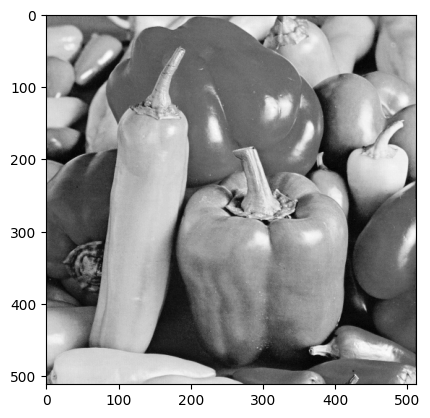

In [ ]:
img = cv.imread('images/peppers.png', cv.IMREAD_GRAYSCALE)
plt.imshow(img, cmap='gray')

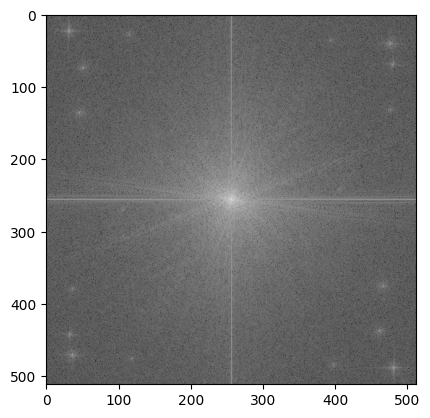

In [ ]:
img_ft = np.fft.fft2(img)
img_ft_shifted = np.fft.fftshift(img_ft)

# visualize the magnitude of the fft
plt.imshow(np.log(np.abs(img_ft_shifted) + 1), cmap='gray')

The FT of an image is much more complex, but the same logic applies. Each number in `image_ft_shifted` is a complex number that represents the contribution of a sine wave to the image. The magnitude of each number is the amplitude of the sine wave, and the angle is the phase.

The sine waves are ordered by frequency, with the lowest frequency in the center and the highest frequency at the edges. Remember that high frequencies correspond to rapid changes in the image, while low frequencies correspond to slow changes.

## Image Compression With the Fourier Transform

Here is a quick overview of how image compression works using the Fourier transform:

1. Apply the Fourier Transform to convert the image from the spatial domain to the frequency domain.
2. Perform frequency-domain filtering by removing or quantizing less significant high-frequency components.
3. Convert the image back to the spatial domain using the inverse Fourier Transform, resulting in a compressed image.
4. Adjust the level of frequency reduction to balance the compression rate with the desired image quality.

In signal processing, a low-pass filter retains low-frequency components while attenuating high-frequency components. This filtering operation is used in image compression to reduce the amount of data needed to represent an image while maintaining its essential features. On the other hand, a high-pass filter emphasizes high-frequency components, and it can be used to enhance edges and textures in an image.

> ### Assignment 2: Low and High-Pass Filters
> 
> #### Task 1: Low-Pass Filtering
>   1. Create a circular mask with high values (1) in the center and low values (0) towards the edges. The size of the central high-value area determines the cutoff frequency.
>   2. Multiply the Fourier-transformed image by this mask to apply the low-pass filter.
>   3. Perform an inverse Fourier Transform to convert back to the spatial domain.
> 
> #### Task 2: High-Pass Filtering
>   1. Construct a mask that is the inverse of the low-pass filter: low values (0) in the center transitioning to high values (1) at the edges.
>   2. Apply this mask to the Fourier-transformed image to implement the high-pass filter.
>   3. Use the inverse Fourier Transform to return to the spatial domain.
>
> **Note:** Remember that `fftshift` is used to center the low frequencies in the Fourier-transformed image. You will need to use `ifftshift` to undo this operation before applying the inverse Fourier Transform.

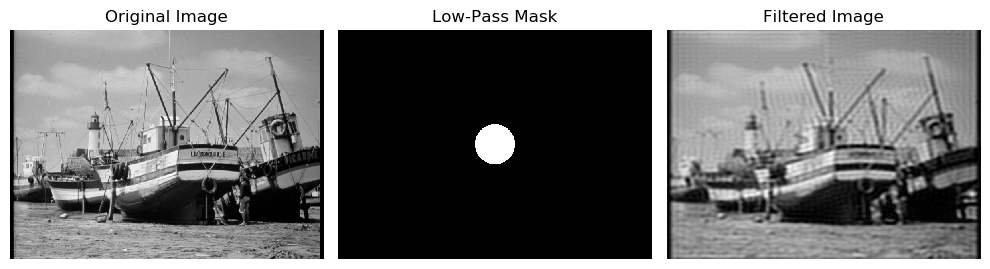

In [34]:
image = cv.imread("./slike/BoatsColor.bmp", cv.IMREAD_GRAYSCALE)
dft = np.fft.fft2(image)
dft_shift = np.fft.fftshift(dft)

rows, cols = image.shape
crow, ccol = rows // 2, cols // 2
radius = 50 

mask = np.zeros((rows, cols), dtype=np.uint8)
cv.circle(mask, (ccol, crow), radius, 1, -1)

filtered_dft = dft_shift * mask

inverse_shift = np.fft.ifftshift(filtered_dft)
filtered_image = np.fft.ifft2(inverse_shift)
filtered_image = np.abs(filtered_image)

plt.figure(figsize=(10, 6))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Low-Pass Mask")
plt.imshow(mask, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Filtered Image")
plt.imshow(filtered_image, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()


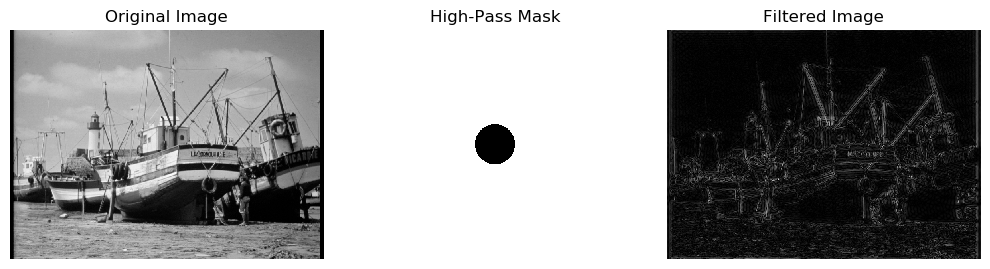

In [35]:
dft = np.fft.fft2(image)
dft_shift = np.fft.fftshift(dft)

rows, cols = image.shape
crow, ccol = rows // 2, cols // 2
radius = 50

mask = np.ones((rows, cols), dtype=np.uint8)
cv.circle(mask, (ccol, crow), radius, 0, -1)

filtered_dft = dft_shift * mask

inverse_shift = np.fft.ifftshift(filtered_dft)
filtered_image = np.fft.ifft2(inverse_shift)
filtered_image = np.abs(filtered_image)

# Visualize the results
plt.figure(figsize=(10, 6))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("High-Pass Mask")
plt.imshow(mask, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Filtered Image")
plt.imshow(filtered_image, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

> ### Assignment 3: Image Compression With FT
> 
> #### Task 1: Identifying and Retaining Top N Frequencies
> 
>    - Convert a grayscale image to the frequency domain using `numpy.fft.fft2()`.
>    - From the magnitude spectrum, identify the top $N$ frequencies with the highest magnitudes. Use `numpy.argsort()` to rank frequencies and select the top $N$. You can use $N = 10^4$ as a good starting point.
>    - Create a mask that retains only these $N$ frequencies, setting all other frequencies to zero. Apply this mask to the Fourier Transform of the image.
> 
> #### Task 2: Image Reconstruction and Compression Evaluation
>    - Inverse-transform the modified frequency representation back to the spatial domain using `numpy.fft.ifft2()`.
>    - Compare the reconstructed image with the original to evaluate the effects of retaining only the top $N$ frequencies.
>    - Discuss the compression achieved and its impact on image quality, particularly noting which features are preserved or lost.

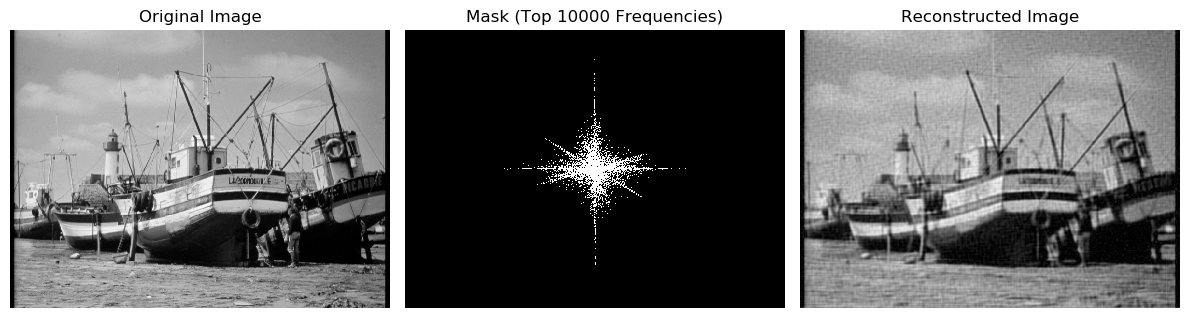

Compression Ratio: 97.79%


In [6]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

image_path = "./slike/BoatsColor.bmp"
image = cv.imread(image_path, cv.IMREAD_GRAYSCALE)

dft = np.fft.fft2(image)
dft_shift = np.fft.fftshift(dft)

magnitude = np.abs(dft_shift)
magnitude_flat = magnitude.flatten()

N = 10**4

top_indices = np.argsort(magnitude_flat)[-N:]
mask = np.zeros_like(magnitude, dtype=np.uint8)
mask_flat = mask.flatten()
mask_flat[top_indices] = 1
mask = mask_flat.reshape(magnitude.shape)

filtered_dft = dft_shift * mask

inverse_shift = np.fft.ifftshift(filtered_dft)
reconstructed_image = np.fft.ifft2(inverse_shift)
reconstructed_image = np.abs(reconstructed_image)

compression_ratio = (1 - N / magnitude.size) * 100

plt.figure(figsize=(12, 8))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title(f"Mask (Top {N} Frequencies)")
plt.imshow(mask, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Reconstructed Image")
plt.imshow(reconstructed_image, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

print(f"Compression Ratio: {compression_ratio:.2f}%")


> ### Assignment 4: Image Compression Coding and Decoding
> 
> #### Task 1: Compression Function
> 
> - **Function**: `compress_image(image, p)`
>   - **Inputs**:
>     - `image`: The input grayscale image.
>     - `p`: The percentage of the top frequencies to retain.
>   - **Process**:
>     1. Convert the image to the frequency domain using the Fourier Transform.
>     2. Identify and retain only the top `p%` of frequencies based on their magnitudes.
>     3. Encode the Fourier Transform as a list of tuples `(x, y, FT coefficient)` for each **non-zero** coefficient, where `x` and `y` are the coordinates in the frequency domain.
>   - **Output**: The coded representation of the image based on non-zero Fourier coefficients.
> 
> #### Task 2: Reconstruction Function
> 
> - **Function**: `reconstruct_image(coded_representation, image_shape)`
>   - **Inputs**:
>     - `coded_representation`: The list of non-zero Fourier coefficients and their positions obtained from the compression function.
>     - `image_shape`: The shape of the original image to guide the reconstruction.
>   - **Process**:
>     1. Recreate the frequency domain representation of the image based on the coded representation.
>     3. Apply an inverse Fourier Transform to convert the frequency domain representation back to the spatial domain, reconstructing the image.
>   - **Output**: The reconstructed image from the coded frequency representation.
> 
> #### Task 3: Analysis and Comparison
> 
>   1. Apply the `compress_image` function to a test image at 1%, 10%, and 100% frequency retention levels to obtain different compressed representations.
>   2. Use the `reconstruct_image` function to reconstruct images from these compressed representations.
>   3. Compare the sizes of the coded representations at each level and calculate the compression ratios. Calculate a compression ratio as the ratio of the original image size to the coded representation size for each level.
>   4. Analyze and discuss the visual quality of the reconstructed images in comparison to the original.

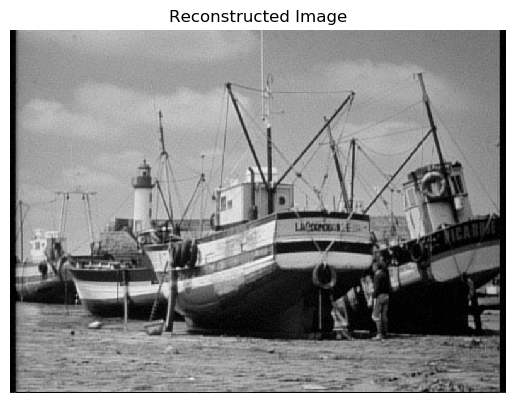

In [12]:
def compress_image(image, p):
    dft = np.fft.fft2(image)
    dft_shift = np.fft.fftshift(dft)
    
    magnitude = np.abs(dft_shift)
    magnitude_flat = magnitude.flatten()

    total_coefficients = magnitude_flat.size
    num_top_frequencies = int(p / 100 * total_coefficients)

    top_indices = np.argsort(magnitude_flat)[-num_top_frequencies:]
    mask = np.zeros_like(magnitude, dtype=np.uint8)
    mask_flat = mask.flatten()
    mask_flat[top_indices] = 1
    mask = mask_flat.reshape(magnitude.shape)

    compressed_dft = dft_shift * mask

    compressed_data = []
    for i in range(magnitude.shape[0]):
        for j in range(magnitude.shape[1]):
            if mask[i, j] == 1:  
                compressed_data.append((i, j, compressed_dft[i, j]))

    return compressed_data

image = cv.imread("./slike/BoatsColor.bmp", cv.IMREAD_GRAYSCALE)

p = 10

compressed_data = compress_image(image, p)

def reconstruct_image(coded_representation, image_shape):
    dft_reconstructed = np.zeros(image_shape, dtype=complex)
    
    for (x, y, coef) in coded_representation:
        dft_reconstructed[x, y] = coef
    
    inverse_shift = np.fft.ifftshift(dft_reconstructed)  
    reconstructed_image = np.fft.ifft2(inverse_shift)    
    reconstructed_image = np.abs(reconstructed_image)
    
    return reconstructed_image

reconstructed_image = reconstruct_image(compressed_data, image.shape)


plt.imshow(reconstructed_image, cmap='gray')
plt.title("Reconstructed Image")
plt.axis('off')
plt.show()